In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install torchvision

     |████████████████████████████████| 1.4MB 746kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import time
import matplotlib.pyplot as plt
import os
import copy

from PIL import Image


## DATASET

In [6]:
dataset = 'chest_xray_reshuffle'
train_directory = os.path.join(dataset,'train')
valid_directory = os.path.join(dataset,'val')
test_directory = os.path.join(dataset,'test')

In [7]:
imgpath_TEST_PNE = os.path.join(test_directory,'PNEUMONIA'), os.listdir(os.path.join(test_directory,'PNEUMONIA'))
imgpath_TEST_NOR = os.path.join(test_directory,'NORMAL'), os.listdir(os.path.join(test_directory,'NORMAL'))
print("imgpath_TEST_PNE",len(imgpath_TEST_PNE[1]))
print("imgpath_TEST_NOR",len(imgpath_TEST_NOR[1]))

imgpath_TEST_PNE 427
imgpath_TEST_NOR 158


In [8]:
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8,1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std  = [0.229,0.224,0.225] )
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std  = [0.229,0.224,0.225] )
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

## Model

In [115]:
model = torch.load('ALEXL001E20.pth')
model.eval()
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [116]:
#summary(model,(3,224,224))

## Select Image

In [146]:
img_selected = 34

test_directory = os.path.join(dataset,'test')
test_data = datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])

idx_to_class = {v:k for k,v in test_data.class_to_idx.items()}
print(idx_to_class)

subset_indices = [img_selected] # select your indices here as a list
subset = torch.utils.data.Subset(test_data, subset_indices)

test_data_size = len(test_data)
test_data_loader = DataLoader(subset, batch_size=1, num_workers=0, shuffle=False)


{0: 'NORMAL', 1: 'PNEUMONIA'}


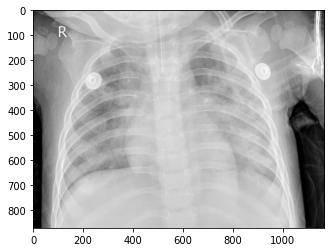

In [147]:
imgpath = os.path.join(os.path.join(test_directory,'PNEUMONIA'), os.listdir(os.path.join(test_directory,'PNEUMONIA'))[img_selected])
img = Image.open(imgpath)
img = img.convert('RGB')
plt.imshow(np.asarray(img))


In [148]:
transform =  transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std  = [0.229, 0.224, 0.225]
    )])

img_t = transform(img)
X = torch.unsqueeze(img_t,0)


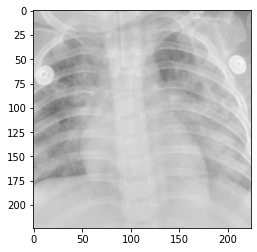

In [149]:
transform2 =  transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()])

img_t2 = transform2(img)

img_p = np.transpose(img_t2.numpy(), (1, 2, 0))
plt.imshow(img_p)

In [150]:
out = model(X)
_, predicted = torch.max(out, 1)
predicted.to('cpu').numpy()

array([1])

In [ ]:
## Activation HeatMaps

In [ ]:
import torch
from torchvision import models, transforms
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
out = model(X)
_, predicted = torch.max(out, 1)
predicted.to('cpu').numpy()

In [ ]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

target_layer = 12  # Choose the layer you want to visualize
model.features[int(target_layer)].register_forward_hook(get_activation(target_layer))

In [ ]:
def generate_heatmap(model, target_layer):
    with torch.no_grad():
        model(X)

    heatmap = activation[target_layer].squeeze().mean(dim=0)
    heatmap = torch.relu(heatmap)

    heatmap /= heatmap.max()

    return heatmap.numpy()

In [ ]:
def plot_heatmap(img, heatmap):

    #plt.imshow(img)
    plt.imshow(heatmap, alpha=0.5, cmap='RdYlBu')
    plt.show()

In [ ]:
heatmap = generate_heatmap(model, target_layer)
plot_heatmap(img, heatmap)

## Salency Maps

In [151]:
#!pip install innvestigate

In [152]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import requests
from PIL import Image

In [153]:
def preprocess(image, size=256):
    transform = T.Compose([
        T.Resize((size,size)),
        T.CenterCrop(size=224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

In [154]:
def deprocess(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])
    return transform(image)

In [155]:
X = preprocess(img)
#X = torch.unsqueeze(img_t,0)
model.eval()
X.requires_grad_()


tensor([[[[-0.3883, -0.2684, -0.1999,  ...,  0.0056,  0.0056,  0.0056],
          [-0.3369, -0.3198, -0.2342,  ...,  0.0741,  0.0398, -0.0287],
          [-0.4226, -0.3369, -0.2342,  ...,  0.2282,  0.1939,  0.0741],
          ...,
          [ 1.0673,  1.4098,  1.5125,  ..., -0.8507, -1.7754, -2.1008],
          [ 1.0673,  1.2899,  1.4954,  ..., -0.7993, -1.7069, -2.1008],
          [ 1.1358,  1.2043,  1.4440,  ..., -0.7650, -1.6213, -2.1008]],

         [[-0.2675, -0.1450, -0.0749,  ...,  0.1352,  0.1352,  0.1352],
          [-0.2150, -0.1975, -0.1099,  ...,  0.2052,  0.1702,  0.1001],
          [-0.3025, -0.2150, -0.1099,  ...,  0.3627,  0.3277,  0.2052],
          ...,
          [ 1.2206,  1.5707,  1.6758,  ..., -0.7402, -1.6856, -2.0182],
          [ 1.2206,  1.4482,  1.6583,  ..., -0.6877, -1.6155, -2.0182],
          [ 1.2906,  1.3606,  1.6057,  ..., -0.6527, -1.5280, -2.0182]],

         [[-0.0441,  0.0779,  0.1476,  ...,  0.3568,  0.3568,  0.3568],
          [ 0.0082,  0.0256,  

In [156]:
scores = model(X)
score_max_index = scores.argmax()
score_max = scores[0,score_max_index]
score_max.backward()

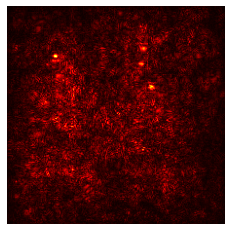

In [157]:
saliency, _ = torch.max(X.grad.data.abs(),dim=1)

# code to plot the saliency map as a heatmap
plt.imshow(saliency[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show()

### PRUEBA 1

In [158]:
pip install captum

Note: you may need to restart the kernel to use updated packages.


In [159]:
pip install flask_compress

Note: you may need to restart the kernel to use updated packages.


In [160]:
import numpy as np
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import visualization as viz
from captum.attr import LRP

In [161]:
ig = IntegratedGradients(model)
attributions = ig.attribute(X, target=1)

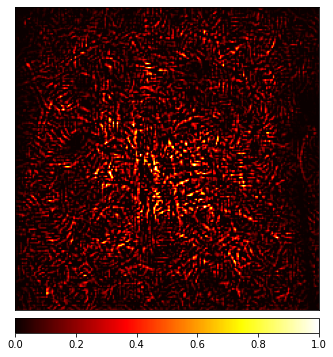

In [162]:
_ = viz.visualize_image_attr(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img_t.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=plt.cm.hot,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

In [163]:
lc2 = LayerConductance(model, model.features[0])
attributions = lc2.attribute(X, target=1)

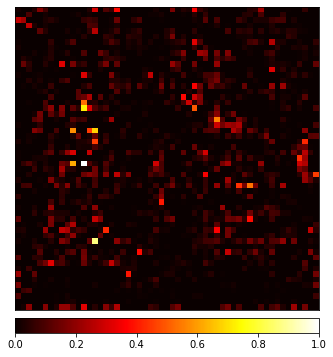

In [164]:
_ = viz.visualize_image_attr(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img_t.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=plt.cm.hot,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)